In [2]:
# Script to remove images smaller than 100x100 pixels
import os
from PIL import Image
import shutil
import time

def remove_small_images(folder_path, min_width=100, min_height=100):
    """
    Remove images that are smaller than the specified dimensions
    
    Args:
        folder_path: Path to the folder containing images
        min_width: Minimum width in pixels
        min_height: Minimum height in pixels
    
    Returns:
        Dictionary with statistics about removed images
    """
    removed_count = 0
    error_count = 0
    total_count = 0
    removed_files = []
    
    # Walk through all subdirectories
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if file is an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                total_count += 1
                
                try:
                    # Open and check image dimensions
                    with Image.open(file_path) as img:
                        width, height = img.size
                        
                        # Remove if smaller than minimum dimensions
                        if width < min_width or height < min_height:
                            img.close()  # Explicitly close the image
                            time.sleep(0.1)  # Small delay to ensure file is released
                            
                            # Try multiple times to remove the file
                            for attempt in range(3):
                                try:
                                    os.remove(file_path)
                                    removed_count += 1
                                    removed_files.append(f"{file} ({width}x{height})")
                                    print(f"Removed: {file_path} - Size: {width}x{height}")
                                    break
                                except PermissionError:
                                    if attempt < 2:
                                        time.sleep(0.5)  # Wait before retry
                                        continue
                                    else:
                                        print(f"Permission denied: {file_path} - Could not remove after 3 attempts")
                                        error_count += 1
                            
                except Exception as e:
                    error_count += 1
                    print(f"Error processing {file_path}: {e}")
    
    return {
        'total_images': total_count,
        'removed_count': removed_count,
        'error_count': error_count,
        'removed_files': removed_files
    }

# Run the cleanup on the Snake Images folder
snake_folder = "Snake Images for Model"
print(f"Scanning {snake_folder} for images smaller than 100x100 pixels...\n")

stats = remove_small_images(snake_folder, min_width=100, min_height=100)

print(f"\n=== CLEANUP SUMMARY ===")
print(f"Total images processed: {stats['total_images']}")
print(f"Images removed: {stats['removed_count']}")
print(f"Errors encountered: {stats['error_count']}")
print(f"Remaining images: {stats['total_images'] - stats['removed_count']}")

if stats['removed_files']:
    print(f"\nRemoved files (first 10):")
    for file_info in stats['removed_files'][:10]:
        print(f"  - {file_info}")
    if len(stats['removed_files']) > 10:
        print(f"  ... and {len(stats['removed_files']) - 10} more files")
else:
    print("\nNo images were removed - all images meet the minimum size requirement!")

Scanning Snake Images for Model for images smaller than 100x100 pixels...

Removed: Snake Images for Model\Eastern Garter Snake\imagesaEBwrRADzPSSBiEqwStBhXVzJV.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagescumtREudhOesRUkAJovLtvBNOI.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesDbWaCBAxFluRxWWfXsJqgGOEQJ.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagescumtREudhOesRUkAJovLtvBNOI.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesDbWaCBAxFluRxWWfXsJqgGOEQJ.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesdunuDuwPOYhLkZSFOzhIJTyTaq.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesEbYDlKEvpbHleCmhrTLfFXGfTl.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesdunuDuwPOYhLkZSFOzhIJTyTaq.jpeg - Size: 50x50
Removed: Snake Images for Model\Eastern Garter Snake\imagesEbYDlKEvpbHleCmhrTLfFXGfTl

In [7]:
%pip install tensorflow keras keras-preprocessing keras-applications split-folders opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input

Found 4483 images belonging to 17 classes.
Found 1691 images belonging to 17 classes.
Found 1691 images belonging to 17 classes.
Found 923 images belonging to 17 classes.
Found 923 images belonging to 17 classes.
Number of snake classes: 17

Class mapping:
0: Black Rat Snake
1: Eastern Garter Snake
2: Eastern Hognose Snake
3: Eastern Massasauga Snake
4: Eastern Milk Snake
5: Eastern Ribbon Snake
6: Eastern Worm Snake
7: Northern Black Racer Snake
8: Northern Brown Snake
9: Northern Copperhead Snake
10: Northern Water Snake
11: Queen Snake
12: Red-Bellied Snake
13: Ring-Necked Snake
14: Rough Green Snake
15: Smooth Green Snake
16: Timber Rattlesnake Snake
Number of snake classes: 17

Class mapping:
0: Black Rat Snake
1: Eastern Garter Snake
2: Eastern Hognose Snake
3: Eastern Massasauga Snake
4: Eastern Milk Snake
5: Eastern Ribbon Snake
6: Eastern Worm Snake
7: Northern Black Racer Snake
8: Northern Brown Snake
9: Northern Copperhead Snake
10: Northern Water Snake
11: Queen Snake
12: R

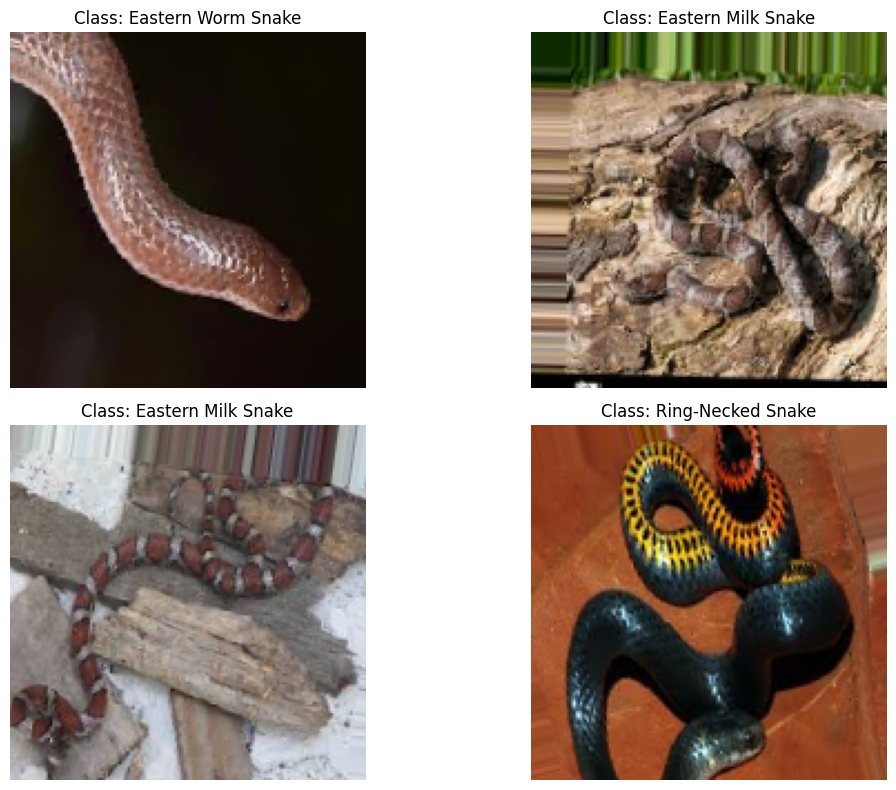

In [9]:
# Split the dataset into train, validation, and test sets
input_folder = "Snake Images for Model"
output_folder = "split_data"

# Split with ratio 70% train, 20% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

# Image parameters - reduced for CNN training
IMG_HEIGHT = 160  # Reduced from 299 to 160
IMG_WIDTH = 160   # Reduced from 299 to 160
BATCH_SIZE = 32

# Simple preprocessing without ResNet preprocessing to avoid double normalization
def simple_preprocessing(img):
    # Simple normalization to [0,1] range
    img = img / 255.0
    return img

# Create image data generators with reduced augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=simple_preprocessing,
    rotation_range=15,               # Reduced from 30 to 15
    width_shift_range=0.1,           # Reduced from 0.2 to 0.1
    height_shift_range=0.1,          # Reduced from 0.2 to 0.1
    shear_range=0.1,                 # Reduced from 0.2 to 0.1
    zoom_range=0.1,                  # Reduced from 0.3 to 0.1
    horizontal_flip=True,
    vertical_flip=False,             # Snake orientation matters
    fill_mode='nearest'              # Changed back to nearest
)

val_datagen = ImageDataGenerator(preprocessing_function=simple_preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=simple_preprocessing)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    f'{output_folder}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    f'{output_folder}/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    f'{output_folder}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of snake classes: {num_classes}")
print("\nClass mapping:")
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_index}: {class_name}")

# Quick sanity check - display a few training images
import matplotlib.pyplot as plt

# Get a batch of training data
batch = next(train_generator)
images, labels = batch

# Display first 4 images from the batch
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    # Get the class name for this image
    class_idx = np.argmax(labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    plt.title(f'Class: {class_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Reset the generator after taking a batch
train_generator.reset()

In [10]:
# Create an improved CNN model with additional conv block
from tensorflow.keras.layers import Input

# Create the model with proper input layer and additional conv block
model = Sequential([
    # Input layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First convolutional block
    Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Fourth convolutional block
    Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Fifth convolutional block (additional)
    Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lowered to 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Quick sanity check training - train for just a few batches
print("\n=== QUICK SANITY CHECK TRAINING ===")
print("Training for 1 epoch to verify everything works...")

# Train for just 1 epoch as sanity check
sanity_history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    verbose=1,
    steps_per_epoch=5,  # Only train on 5 batches for quick check
    validation_steps=2  # Only validate on 2 batches
)

print(f"Sanity check completed!")
print(f"Training accuracy: {sanity_history.history['accuracy'][0]:.4f}")
print(f"Validation accuracy: {sanity_history.history['val_accuracy'][0]:.4f}")
print("If this looks reasonable, proceed with full training...")

# Reset generators for actual training
train_generator.reset()
validation_generator.reset()

# Training parameters
BATCH_SIZE = 16      # Reduced batch size for stability
epochs = 25          # Reasonable number of epochs

# Recreate generators with proper batch size for full training
train_generator = train_datagen.flow_from_directory(
    f'{output_folder}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    f'{output_folder}/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n=== STARTING FULL TRAINING ===")

# Train the model with simplified callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[
        # Early stopping with reasonable patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateauing
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # Model checkpoint with modern format
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,951,441 (15.07 MB)

 Trainable params: 3,950,225 (15.07 MB)

 Non-trainable params: 1,216 (4.75 KB)


=== QUICK SANITY CHECK TRAINING ===
Training for 1 epoch to verify everything works...
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.0812 - loss: 3.9099 - val_accuracy: 0.0312 - val_loss: 2.8288
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.0812 - loss: 3.9099 - val_accuracy: 0.0312 - val_loss: 2.8288
Sanity check completed!
Training accuracy: 0.0812
Validation accuracy: 0.0312
If this looks reasonable, proceed with full training...
Sanity check completed!
Training accuracy: 0.0812
Validation accuracy: 0.0312
If this looks reasonable, proceed with full training...
Found 4483 images belonging to 17 classes.
Found 4483 images belonging to 17 classes.
Found 1691 images belonging to 17 classes.
Found 1691 images belonging to 17 classes.

=== STARTING FULL TRAINING ===

=== STARTING FULL TRAINING ===
Epoch 1/25
Epoch 1/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.0886 - loss: 3.0377
Epoch 1: val_accuracy improved from None to 0.07983, saving model to best_model.ker

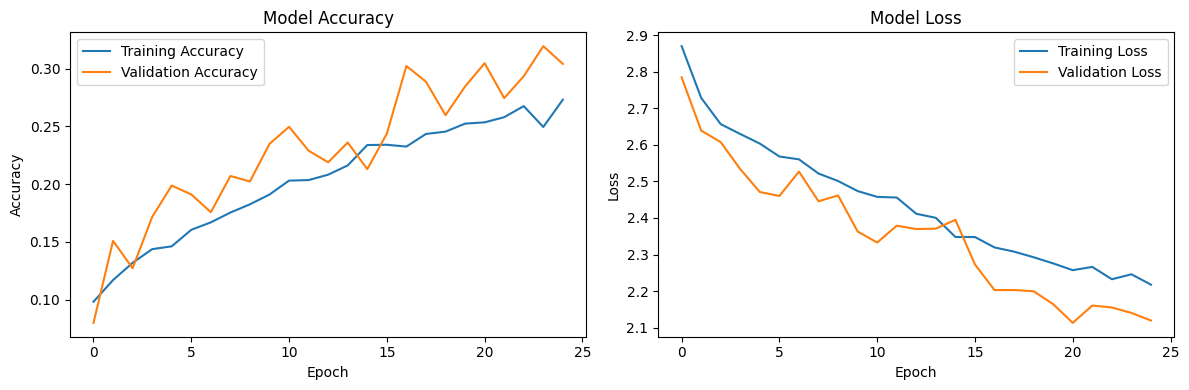

Found 923 images belonging to 17 classes.
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.3272 - loss: 2.0829

Test accuracy: 0.3272
Test loss: 2.0829
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.3272 - loss: 2.0829

Test accuracy: 0.3272
Test loss: 2.0829


In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_generator_eval = test_datagen.flow_from_directory(
    f'{output_folder}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator_eval)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Function to predict and display results for a single image
def predict_snake(image_path):
    # Load and preprocess the image with simple preprocessing
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array = simple_preprocessing(img_array)  # Use our simple preprocessing
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Get class name
    class_names = list(train_generator.class_indices.keys())
    predicted_snake = class_names[predicted_class]
    
    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_snake}\nConfidence: {confidence:.2%}')
    plt.show()
    
    # Print top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {predictions[0][idx]:.2%}")

# Example usage (uncomment to test with an actual image):
# predict_snake("path_to_your_snake_image.jpg")